In [1]:
import math

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import idx2numpy
import gzip

mpl.rc('image', cmap='gray')
sys.path.append('..')

from cnsproject.network.neural_populations import (
    LIFPopulation,
    InputPopulation
)
from cnsproject.network.connections import ConvolutionalConnection
from cnsproject.encoding.encoders import Time2FirstSpikeEncoder
from cnsproject.network.monitors import Monitor
from cnsproject.network.network import Network
from cnsproject.filtering.filters import dog_filter
from cnsproject.learning.learning_rules import STDP
from cnsproject.utils import read_images, crop_center

%matplotlib inline

In [2]:
def run_simulation(images_tensor, conv_filter, **kwargs):
    sim_time: int = kwargs.get("sim_time", 10)
    conv_th: int = kwargs.get("conv_th", -57)
    c_shape: tuple = kwargs.get("c_shape", (100, 100))
    conv_k_size: int = kwargs.get("conv_k_size", 13)
    c_stride: int = kwargs.get("c_stride", 1)
    lr: list = kwargs.get("lr", [0.0001, 0.01])
    do_norm: bool = kwargs.get("do_norm", True)
    is_flat: bool = kwargs.get("is_flat", False)
    do_lateral: bool = kwargs.get("do_lateral", False)
    lat_k_size: int = kwargs.get("lat_k_size", 5)
    lat_sigma: float = kwargs.get("lat_sigma", 2.)
    lat_int: float = kwargs.get("lat_int", 0.5)
    kwta: int = kwargs.get("kwta", None)
    dog_k: int = kwargs.get("dog_k", 5)
    apply_dog: bool = kwargs.get("apply_dog", True)
    sig1: float = kwargs.get("dog_sig1")
    sig2: float = kwargs.get("dog_sig2")
    tau_s = sim_time
    tau = sim_time * 2

    in_layer = InputPopulation(
        (images_tensor[0].shape[0], images_tensor[0].shape[1])
    )
    conv_layer = LIFPopulation(
        c_shape, threshold=conv_th,
        tau_s=tau_s, tau=tau,
        kwta=kwta,
        do_lateral_inhibit=do_lateral,
        lat_sigma=lat_sigma,
        lat_k_size=lat_k_size,
        lat_inh_int=lat_int,
    )
    conv_connection = ConvolutionalConnection(
        in_layer, conv_layer,
        learning_rule=STDP,
        do_normalize_weights=do_norm,
        lr=lr,
        is_flat=is_flat,
        kernel_size=conv_k_size,
        padding=0,
        strides=c_stride,
        w=conv_filter,
        wmin=-1, wmax=1.
    )
    weight_monitor = Monitor(conv_connection, state_variables=["w"])
    t2fs_encoder = Time2FirstSpikeEncoder(sim_time, data_max_val=1.)
    net = Network(learning=True)
    net.add_layer(in_layer, "in_layer")
    net.add_layer(conv_layer, "conv_layer")
    net.add_connection(conv_connection, "in_layer", "conv_layer")
    net.add_monitor(weight_monitor, "weight_monitor")
    net.reset_state_variables()
    conv_curr = torch.zeros(sim_time, *conv_layer.shape)
    input_dict = dict(conv_layer=conv_curr)
    p = dog_k // 2
    if sig1 == sig2 is None:
        if dog_k in [7, 9]:
            sig1 = 1.25
            sig2 = 3
        elif dog_k == 5:
            sig1 = 1.25
            sig2 = 1.5
        else:
            sig1 = 1.5
            sig2 = 9
    dog = dog_filter(dog_k, sig1, sig2)
    dog = torch.tensor(dog, dtype=torch.float32)
    w, h = images_tensor[0].shape[1], images_tensor[0].shape[0]
    encoded = None
    i = 0
    for image in (images_tensor):
        if apply_dog:
            dog_applied_image = F.conv2d(
                image.view(1, 1, w, h),
                dog.view(1, 1, dog_k, dog_k),
            ).squeeze()
            # Normalize data in range [0, 1]
            dog_applied_image -= dog_applied_image.min()
            dog_applied_image /= dog_applied_image.max()
        else:
            dog_applied_image = image

        encoded = t2fs_encoder(dog_applied_image)
        encoded = torch.unsqueeze(encoded, 1)
        if apply_dog:
            encoded = F.pad(encoded, (p,) * 4, mode="replicate")

        input_dict["in_layer"] = encoded
        net.run(sim_time, current_inputs=input_dict)
        conv_connection.pre.reset_state_variables()
        conv_connection.post.reset_state_variables()

    return net, encoded


def draw_plots(
        s_conv,
        weights,
        encoded,
        title: str = None,
        figsize=(12, 5)
):
    fig, axs = plt.subplots(3, len(s_conv), figsize=figsize)
    ax = axs[0]
    ax[0].set_ylabel('Input(Encoding)')
    for i in range(len(s_conv)):
        ax[i].imshow(encoded[i])
    ax = axs[1]
    ax[0].set_ylabel('Convolution')
    for i in range(len(s_conv)):
        ax[i].imshow(s_conv[i])
    ax = axs[2]
    ax[0].set_ylabel('Weights')
    for i in range(len(s_conv)):
        ax[i].imshow(weights[i])
    for i in range(len(ax)):
        ax[i].set_xlabel(f'${i}ms$')

    for ax in axs:
        for i in range(len(ax)):
            ax[i].set_yticks([])
            ax[i].set_xticks([])
    if title is None:
        title = 'Simulation Outputs'
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

def draw_weights(weights: torch.Tensor, images_len, title=None):
    if title is None:
        title = "Weights"
    weights = torch.squeeze(weights)
    weights_reshaped = weights.permute(1, 0, 2, 3).view(
        f, images_len, sim_time, k_size, k_size
    )
    w = weights_reshaped[:, :, 0]

    if round(math.sqrt(f)) == math.sqrt(f):
        rows = cols = int(math.sqrt(len(w)))
        fig, axs = plt.subplots(rows, cols, figsize=(rows, cols))
        for j in range(len(axs)):
            ax = axs[j]
            for i in range(len(ax)):
                ax[i].matshow(w[j * rows + i, -1])
                ax[i].set_xticks([])
                ax[i].set_yticks([])
    else:
        cols = len(w)
        fig, axs = plt.subplots(1, cols, figsize=(cols, 1.5))
        for i in range(len(axs)):
            axs[i].matshow(w[i, -1])
            axs[i].set_xticks([])
            axs[i].set_yticks([])
    plt.suptitle(title)
    plt.show()

def draw_filter(mat, title=None):
    if title is None:
        title = 'Weights'
    fig, ax = plt.subplots(1, figsize=(1, 1))
    ax.matshow(mat)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.title(title, fontdict={'size': 9})
    plt.show()

In [167]:
num_images = 3000
mnist = True
if mnist:
    classes = [0, 2, 1, 5,]
    num_images = int(num_images * 10 / len(classes))
    file = gzip.open('data/train-images-idx3-ubyte.gz', 'rb')
    images = idx2numpy.convert_from_file(file)
    file.close()
    file = gzip.open('data/train-labels-idx1-ubyte.gz', 'rb')
    y_train = idx2numpy.convert_from_file(file)
    file.close()
    images = images[:num_images]
    y_train = y_train[:num_images]

    images = np.asarray([images[i] for i, l in enumerate(y_train)
                         if False or l in classes])
    images = images.astype(np.float32) / 255
else:
    images = read_images("images/101_ObjectCategories/Faces_easy", None,
                         sort=False)
    s = 260
    images = [
        crop_center(im, s, s) for im in images
        if im.shape[0] >= s and im.shape[1] >= s
    ]
    images = images[:num_images]
    images = [cv2.resize(im, (62, 62)) for im in images]
    images = np.asarray(images).astype(np.float32)

np.random.shuffle(images)
np.random.shuffle(images)
images_tensor = torch.from_numpy(images)

# Introduction

In this project, we implement `K-winners Take All` and `Lateral Inhibition`
mechanisms; then train a simple Convolutional Spiking Neural Network (SNN)
using MNIST and Caltech datasets. Multiple parameters' effect are tested on the
training process.

When using `KWTA` only K neurons (winners) can spike for each input image, and these K spikes
should be selected from different feature maps
($K\leq NumFilters$). Winner neurons activate the lateral inhibition and prevent
adjacent neurons in other filters to spike.

The steps for the training are as follows:

1. Resize the images to the same shape
2. Apply a DoG filter on the images
3. Encode the images using Time2FirstSpike encoder
4. Apply Convolution on the encoded data
5. Update the weights using `STDP` rule modulated with `KWTA` and `Lateral Inhibition`.

**Note**: A Gaussian kernel is used for Lateral Inhibition.

# Part 1 (MNIST dataset)

We use only four digits ($0, 1, 2, 5$) of this dataset to simplify the process.


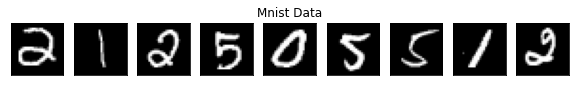

In [168]:
fig, ax = plt.subplots(1, 9, figsize=(10, 3))
k = torch.randint(0, len(images_tensor), (len(ax),))
for i in range(len(ax)):
    ax[i].imshow(images_tensor[k[i]])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[4].title.set_text("Mnist Data")
plt.show()

**Default Parameters**:

Input and Learning Parameters:

$NumImages\approx 3000$

$ImageSize = 28\times28$

$FilterSize = 21\times21$

$EncodeTime = 5ms$

$NumFilters=8$

$K=\frac 1 4 NumFilter$

$LearningRate = [0.02, 0.2]$

$DoG_{KernelSize} = 5, DoG_{\sigma_1}=1.5, DoG_{\sigma_2}=15$

Lateral Inhibition Params:

$KernelSize = Convolution FilterSize$

$\sigma=\frac1 3 Convolution FilterSize$

$Multiplier = 15$

Convolution Layer Neuron Parameters:

$\tau=10ms$

$\tau_s=5ms$

$threshold=-57.5mv$

$u_{rest}=-60mv$


You can see the dog filter, filtering and encoding output below.

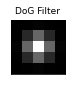

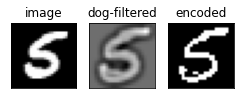

In [225]:
dog = dog_filter(5, 0.75, 15)
dog = torch.tensor(dog, dtype=torch.float32)
draw_filter(dog, title="DoG Filter")
t2fs_encoder = Time2FirstSpikeEncoder(5, data_max_val=1.)
image = images_tensor[0]
w, h = images_tensor[0].shape[1], images_tensor[0].shape[0]
dog_applied_image = F.conv2d(
    image.view(1, 1, w, h),
    dog.view(1, 1, 5, 5),
).squeeze()
# dog_applied_image = relu_normalize(dog_applied_image)
dog_applied_image -= dog_applied_image.min()
dog_applied_image /= dog_applied_image.max()
encoded = t2fs_encoder(dog_applied_image)
fig, ax = plt.subplots(1, 3, figsize=(4, 4))
ax[2].imshow(encoded[:2].sum(0).squeeze())

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[1].imshow(dog_applied_image)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].imshow(image)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].title.set_text("image")
ax[1].title.set_text("dog-filtered")
ax[2].title.set_text("encoded")
plt.show()

## KernelSize

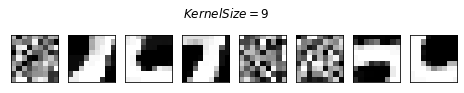

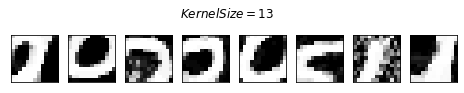

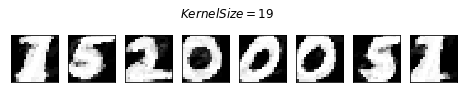

In [173]:
f = 8
kwta = f // 4
sim_time = 5
kernels = None
lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
if kwta is not None:
    lr = [0.02, 0.2] if mnist else [0.02, 0.9]
for k_size in [9, 13, 19]:
    c = images[0].shape[0] - k_size + 1
    net, encoded = run_simulation(
        images_tensor,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        conv_th=-57.5,
        dog_k=5,
        dog_sig1=0.75,
        dog_sig2=15
    )

    weights = net.monitors.get("weight_monitor").get("w")
    title = f"$KernelSize={k_size}$"
    draw_weights(weights, len(images_tensor), title=title)

If KernelSize is smaller than the input images, the filters tend to learn
parts of the input images like curves or oriented lines of digits. When
$KernelSize=19$, filters can learn the entire digits separately.

## #Filters

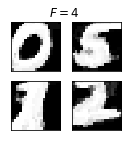

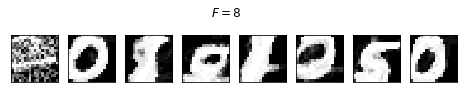

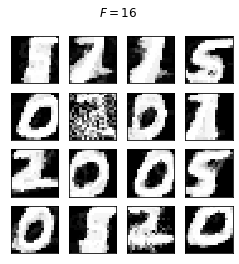

In [176]:
sim_time = 5
k_size = 19
kernels = None
lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
if kwta is not None:
    lr = [0.02, 0.2] if mnist else [0.02, 0.9]
for f in [4, 8, 16]:
    kwta = f // 4
    c = images[0].shape[0] - k_size + 1
    net, encoded = run_simulation(
        images_tensor,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        conv_th=-57.5,
        dog_k=5,
        dog_sig1=0.75,
        dog_sig2=15
    )

    weights = net.monitors.get("weight_monitor").get("w")
    title = f"$F={f}$"
    draw_weights(weights, len(images_tensor), title=title)


Since we only use four digits, 4 filters could be enough to learn them. By increasing
the filters number, some filters might not learn anything, and some of them may learn
shapes that are similar to two or more digits.

## K

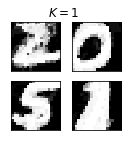

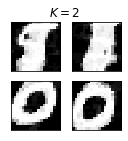

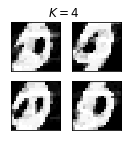

In [187]:
sim_time = 5
k_size = 19
f = 4
kernels = None
kwta = 1
lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
if kwta is not None:
    lr = [0.02, 0.2] if mnist else [0.02, 0.9]
for kwta in [1, 2, 4]:
    c = images[0].shape[0] - k_size + 1
    net, encoded = run_simulation(
        images_tensor,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        conv_th=-57.5,
        dog_k=5,
        dog_sig1=0.75,
        dog_sig2=15
    )

    weights = net.monitors.get("weight_monitor").get("w")
    title = f"$K={kwta}$"
    draw_weights(weights, len(images_tensor), title=title)

If $\frac F K = NumClasses$, every feature tends to learn one digit. But when
$\frac F K \leq NumClasses$, filters tend to learn shared and/or mixed features
of digits.

## Lateral Inhibition

### KernelSize

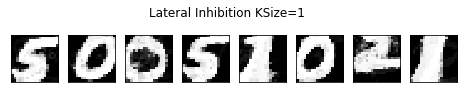

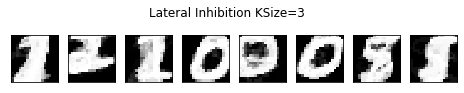

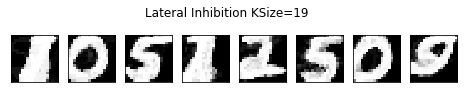

In [196]:
sim_time = 5
k_size = 19
f = 8
kernels = None
kwta = 2
lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
if kwta is not None:
    lr = [0.02, 0.2] if mnist else [0.02, 0.9]
for lat_k in [1, 3, 19]:
    c = images[0].shape[0] - k_size + 1
    net, encoded = run_simulation(
        images_tensor,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=lat_k,
        lat_sigma=k_size / 3,
        conv_th=-57.5,
        dog_k=5,
        dog_sig1=0.75,
        dog_sig2=15
    )

    weights = net.monitors.get("weight_monitor").get("w")
    title = f"Lateral Inhibition KSize={lat_k}"
    draw_weights(weights, len(images_tensor), title=title)


From the above figures we conclude that the Lateral Inhibition KernelSize does
not change the learned weights meaningfully in our setting. A possible reason is
that our encoding time is short (also the pixel values are almost binary)
and often all winners are found in the same
time step, so the inhibition will not get the chance to make its effect visible.
Due to this reason other parameters of lateral inhibition possibly do not have
any visible effect.

# Part 2 (Caltech dataset: Faces_easy)

In this section we only provide some outputs without discussing the effect of
parameters.

The images' size are $62\times62$.

In [3]:
num_images = -1
mnist = False
if mnist:
    classes = [0, 2, 1, 5,]
    num_images = int(num_images * 10 / len(classes))
    file = gzip.open('data/train-images-idx3-ubyte.gz', 'rb')
    images = idx2numpy.convert_from_file(file)
    file.close()
    file = gzip.open('data/train-labels-idx1-ubyte.gz', 'rb')
    y_train = idx2numpy.convert_from_file(file)
    file.close()
    images = images[:num_images]
    y_train = y_train[:num_images]

    images = np.asarray([images[i] for i, l in enumerate(y_train)
                         if False or l in classes])
    images = images.astype(np.float32) / 255
else:
    images = read_images("images/101_ObjectCategories/Faces_easy", None,
                         sort=False)
    s = 260
    images = [
        crop_center(im, s, s) for im in images
        if im.shape[0] >= s and im.shape[1] >= s
    ]
    images = images[:num_images]
    images = [cv2.resize(im, (62, 62)) for im in images]
    images = np.asarray(images).astype(np.float32)

np.random.shuffle(images)
np.random.shuffle(images)
images_tensor_c = torch.from_numpy(images)

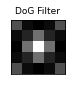

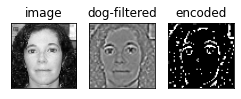

In [396]:
dog = dog_filter(5, 1.25, 1.5)
dog = torch.tensor(dog, dtype=torch.float32)
draw_filter(dog, title="DoG Filter")
t2fs_encoder = Time2FirstSpikeEncoder(10, data_max_val=1.)
k = np.random.randint(0, len(images_tensor_c), 1)
image = images_tensor_c[k[0]]
w, h = images_tensor_c[0].shape[1], images_tensor_c[0].shape[0]
dog_applied_image = F.conv2d(
    image.view(1, 1, w, h),
    dog.view(1, 1, 5, 5),
).squeeze()
# dog_applied_image = relu_normalize(dog_applied_image)
dog_applied_image -= dog_applied_image.min()
dog_applied_image /= dog_applied_image.max()
encoded = t2fs_encoder(dog_applied_image)
fig, ax = plt.subplots(1, 3, figsize=(4, 4))
ax[2].imshow(encoded[:4].sum(0).squeeze())

ax[2].set_xticks([])
ax[2].set_yticks([])
ax[1].imshow(dog_applied_image)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[0].imshow(image)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].title.set_text("image")
ax[1].title.set_text("dog-filtered")
ax[2].title.set_text("encoded")
plt.show()

## Parameter Set 1

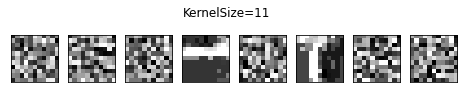

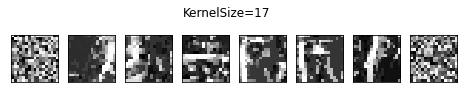

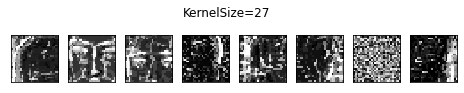

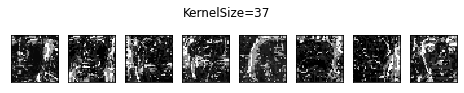

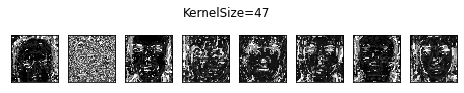

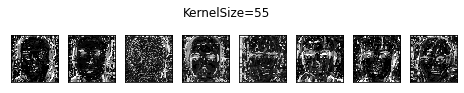

In [14]:
f = 8
sim_time = 10
kernels = None

for k_size in [11, 17, 27, 37, 47, 55]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [1, 0.15]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        dog_k=5,
        dog_sig1=1.25,
        dog_sig2=2,
        conv_th=-50,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)


## Parameter Set 2

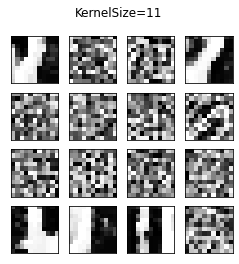

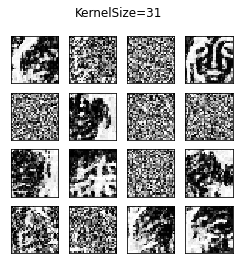

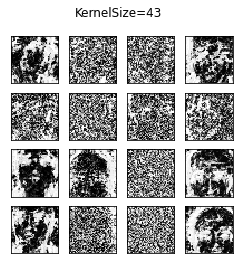

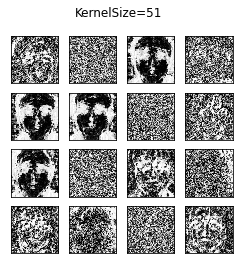

In [11]:
f = 16
kwta = 4
sim_time = 10
kernels = None

for k_size in [11, 31, 43, 51]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [0.2, 0.2]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        dog_k=7,
        conv_th=-50,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)

## Parameter Set 3

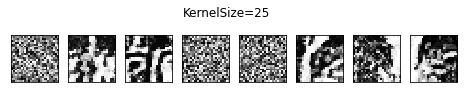

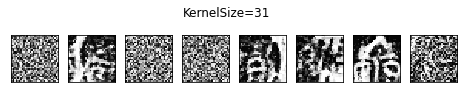

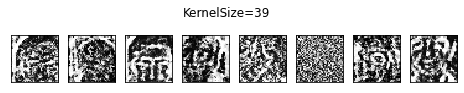

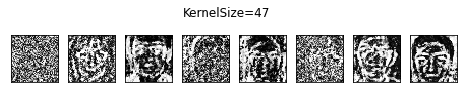

In [10]:
f = 8
kwta = 2
sim_time = 7
kernels = None

for k_size in [25, 31, 39, 47]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [0.3, 0.2]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        dog_k=7,
        conv_th=-52,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)

## Parameter Set 4

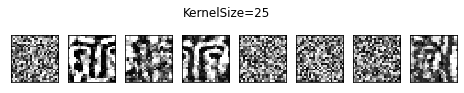

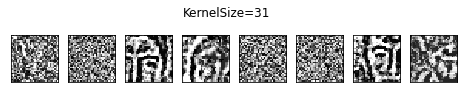

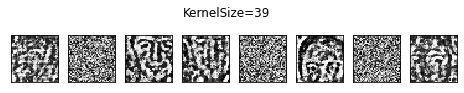

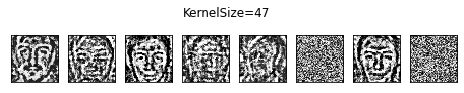

In [13]:
f = 8
kwta = 2
sim_time = 5
kernels = None

for k_size in [25, 31, 39, 47]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [0.5, 0.5]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        lat_int=15,
        lat_k_size=k_size,
        lat_sigma=k_size / 3,
        dog_k=7,
        conv_th=-52,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)


## Parameter Set 5

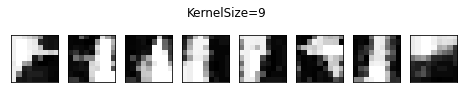

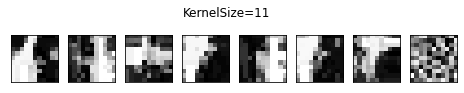

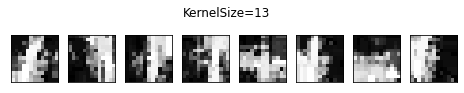

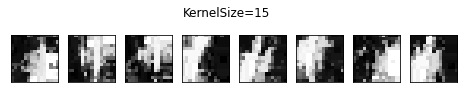

In [12]:
kwta = 4
kernels = None
sim_time = 10
f = 8
for k_size in [9, 11, 13, 15]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [0.5, 0.5]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        dog_k=7,
        dog_sig1=1,
        dog_sig2=9,
        conv_th=-57,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)

## Parameter Set 6 (no KWTA and Lateral Inhibition)

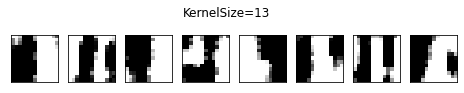

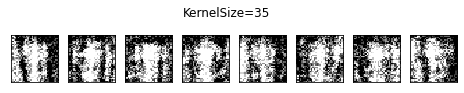

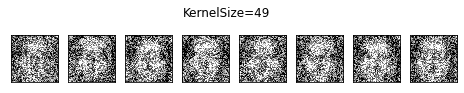

In [20]:
f = 8
kwta = None
sim_time = 10
kernels = None

for k_size in [13, 35, 49]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [0.5, 0.5]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        dog_k=7,
        dog_sig1=1,
        dog_sig2=9,
        conv_th=-57,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)


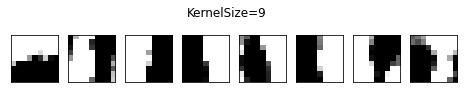

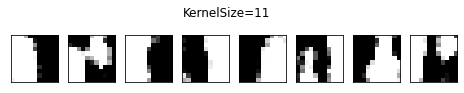

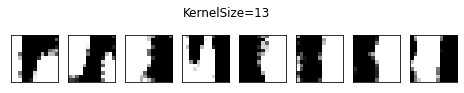

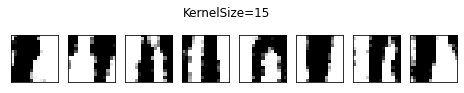

In [22]:
for k_size in [9, 11, 13, 15]:
    c = images[0].shape[0] - k_size + 1
    lr = [0.001, 0.002] if mnist else [0.00001, 0.000075]
    if kwta is not None:
        lr = [0.02, 0.2] if mnist else [0.5, 0.5]
    net, encoded = run_simulation(
        images_tensor_c,
        kernels,
        sim_time=sim_time,
        c_shape=(f, c, c),
        lr=lr,
        conv_k_size=k_size,
        kwta=kwta,
        dog_k=7,
        dog_sig1=1,
        dog_sig2=9,
        conv_th=-57,
    )
    weights = net.monitors.get("weight_monitor").get("w")
    title = f"KernelSize={k_size}"
    draw_weights(weights, len(images_tensor_c), title=title)


# Summary

1. By increasing `K`, redundancy of the learned features will increase, and the
features will be less specific.
For example, in MNIST dataset with four digits, when we set $F=K$, all
filters learn almost the same feature which is not desired. This is due to
the fact that every digit will update every feature. So the output features
will be almost the same and not be specific to one digit.

2. We expect to get $\frac F K$ different types of features. Again, considering
the MNIST experiments, when we set $K = 2$ and $F = 8$, in most cases (different weight
initializations)
each digit will have two dedicated features.

3. According to previous facts, we can control the redundancy and specificness
of the learned weights with `K` and `F`.

4. Filters with small KernelSize tend to learn simple features such as oriented
lines or a combination of multiple lines or simple curves (like a part of a digit).
However, filters with larger KernelSize tend to learn the whole data.

5. Without using `KWTA` and `Lateral Inhibition` the learned features are more
general and may not be specific of the input data. In this setting
large features noisy and redundant, but small features learn general oriented
lines and simple curves successfully.

6. Based on the previous observation, we could say that `KWTA` performs better
with large kernel sizes (large receptive fields).